In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('C:\\Users\\retr0\\Downloads\\financial-inclusion-in-africa-iaio-practice-challenge20240828-1156-gya18v\\Train.csv')

In [9]:
df['bank_account'] = df['bank_account'].map({'Yes' : 1, 'No' : 0})

In [11]:
df['year'] = df['year'] % 100

In [13]:
df['cellphone_access'] = df['cellphone_access'].map({'Yes' : 1, 'No' : 0})

In [15]:
X = df.drop(['bank_account', 'uniqueid'], axis = 1)
y = df['bank_account']
y.value_counts()

bank_account
0    20212
1     3312
Name: count, dtype: int64

In [17]:
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss

In [32]:
best_params = {
    'objective' : 'Logloss',
    'colsample_bylevel' : 0.0697200346162589,
    'depth' : 7,
    'boosting_type': 'Ordered',
    'bootstrap_type' : 'MVS'
}

cat_features = ['country', 'location_type', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

In [33]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    break

In [19]:
y.value_counts()

bank_account
0    20212
1     3312
Name: count, dtype: int64

In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    brier_scores = []
    f1_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        cat_features = ['country', 'location_type', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
        model = CatBoostClassifier(**param, cat_features = cat_features, verbose = False)
        model.fit(X_train, y_train)

        y_preds_proba = model.predict_proba(X_test)[:, 1]
        y_preds = model.predict(X_test)
        brier = brier_score_loss(y_test, y_preds_proba)
        f1 = f1_score(y_test, y_preds)
        f1_scores.append(f1)
        # print(brier)
        brier_scores.append(brier)
    print(f'Brier score: {np.mean(brier_scores)}, F1_score: {np.mean(f1_scores)}')
    return np.mean(brier_scores)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 25)

best_params = study.best_params
print(best_params)

[I 2024-09-02 18:05:23,455] A new study created in memory with name: no-name-da0ee189-cf78-401c-82d0-ffb3b46b528f
[I 2024-09-02 18:06:35,778] Trial 0 finished with value: 0.08473805569362979 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04660844781293266, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.08473805569362979, F1_score: 0.45052048982566084


[I 2024-09-02 18:08:04,197] Trial 1 finished with value: 0.08578491728078695 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04698809206891366, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.08578491728078695, F1_score: 0.43811971236285796


[I 2024-09-02 18:09:01,618] Trial 2 finished with value: 0.08917619346690196 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.026464272379018938, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9041928497346181}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.08917619346690196, F1_score: 0.3695275615418421


[I 2024-09-02 18:10:43,379] Trial 3 finished with value: 0.08546273035981741 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.054854247642866207, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.08788752968831}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.08546273035981741, F1_score: 0.4449565884226758


[I 2024-09-02 18:11:57,006] Trial 4 finished with value: 0.08514368674134232 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07230070233684334, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1580719297052853}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.08514368674134232, F1_score: 0.45242649185854056


[I 2024-09-02 18:12:54,708] Trial 5 finished with value: 0.09690731362912422 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.013963229359847937, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37367085128989797}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.09690731362912422, F1_score: 0.13982052329729705


[I 2024-09-02 18:13:52,450] Trial 6 finished with value: 0.09990317232753106 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.010721705235785237, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1892683493957777}. Best is trial 0 with value: 0.08473805569362979.


Brier score: 0.09990317232753106, F1_score: 0.05802621998586227


[I 2024-09-02 18:16:02,956] Trial 7 finished with value: 0.08346119321597481 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09821629423091673, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.08346119321597481.


Brier score: 0.08346119321597481, F1_score: 0.4714477278449771


[I 2024-09-02 18:17:10,261] Trial 8 finished with value: 0.08532240820289481 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04443946724438158, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.637502507949776}. Best is trial 7 with value: 0.08346119321597481.


Brier score: 0.08532240820289481, F1_score: 0.44441460363417323


[I 2024-09-02 18:18:12,808] Trial 9 finished with value: 0.08721881715855576 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.033553088089358474, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.18687090337324577}. Best is trial 7 with value: 0.08346119321597481.


Brier score: 0.08721881715855576, F1_score: 0.40371433136793977


[I 2024-09-02 18:20:52,776] Trial 10 finished with value: 0.08348749470263624 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09989081328666344, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.08346119321597481.


Brier score: 0.08348749470263624, F1_score: 0.475549996255741


[W 2024-09-02 18:21:10,924] Trial 11 failed with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09979614171366492, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\retr0\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\retr0\AppData\Local\Temp\ipykernel_38524\2942640160.py", line 27, in objective
    model.fit(X_train, y_train)
  File "C:\Users\retr0\anaconda3\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\retr0\anaconda3\Lib\site-packages\catboost\core.py", line 2400, in _fit
    self._train(
  File "C:\Users\retr0\anaconda3\Lib\site-packages\catboost\core.py", line 1780

In [27]:
best_params = {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09821629423091673, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}

In [35]:
cat_features = ['country', 'location_type', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
model = CatBoostClassifier(**best_params, verbose = False, cat_features = cat_features)
model.fit(X_train, y_train)

In [37]:
model.predict(X_test)
print(model.score(X_test, y_test))
y_preds = model.predict(X_test)
print(accuracy_score(y_preds, y_test))
print(f1_score(y_preds, y_test))

0.887778958554729
0.887778958554729
0.4634146341463415


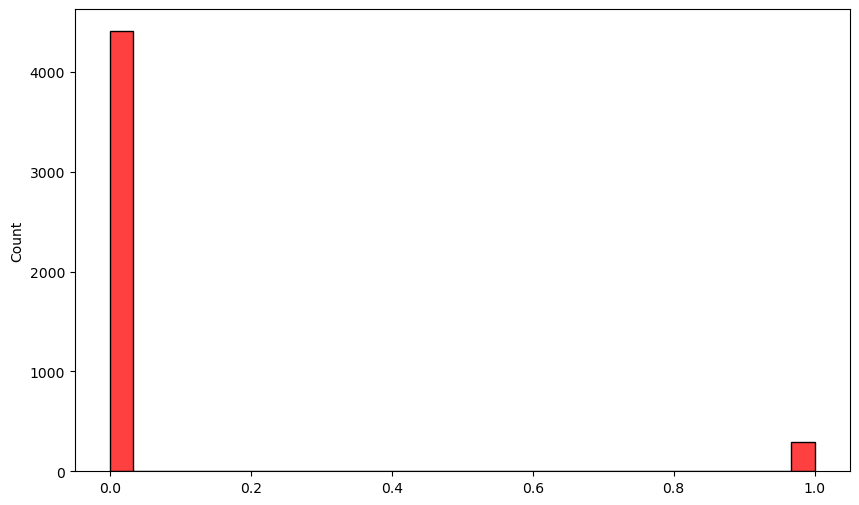

In [92]:
plt.figure(figsize = (10, 6))
sns.histplot(y_preds, color = 'red', bins = 30)
plt.show()

In [39]:
predicted_probabilities = model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
thresholds

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89])

In [43]:
best_score = 0
best_threshold = -1

for threshold in thresholds:
    predicted_classes = (predicted_probabilities >= threshold).astype(int)

    f1 = f1_score(predicted_classes , y_test)
    brier = brier_score_loss(y_test, predicted_probabilities)
    print(f'F1_score : {f1}, Brier_score: {brier} for the threshold: {threshold}')
    if f1 > best_score:
        best_score = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold} for the f1_score: {best_score}')

F1_score : 0.47418244406196214, Brier_score: 0.08440560982059443 for the threshold: 0.1
F1_score : 0.48334833483348333, Brier_score: 0.08440560982059443 for the threshold: 0.11
F1_score : 0.49764816556914393, Brier_score: 0.08440560982059443 for the threshold: 0.12
F1_score : 0.5037110341415141, Brier_score: 0.08440560982059443 for the threshold: 0.13
F1_score : 0.5232375979112271, Brier_score: 0.08440560982059443 for the threshold: 0.13999999999999999
F1_score : 0.5315068493150685, Brier_score: 0.08440560982059443 for the threshold: 0.14999999999999997
F1_score : 0.538678712591756, Brier_score: 0.08440560982059443 for the threshold: 0.15999999999999998
F1_score : 0.5424721734036321, Brier_score: 0.08440560982059443 for the threshold: 0.16999999999999998
F1_score : 0.548714883442917, Brier_score: 0.08440560982059443 for the threshold: 0.17999999999999997
F1_score : 0.5544554455445545, Brier_score: 0.08440560982059443 for the threshold: 0.18999999999999995
F1_score : 0.5509816339455351,

In [120]:
df_testing = pd.read_csv('C:\\Users\\retr0\\Downloads\\financial-inclusion-in-africa-iaio-practice-challenge20240828-1156-gya18v\\Test.csv')

df_testing['year'] = df_testing['year'] % 100
df_testing['cellphone_access'] = df_testing['cellphone_access'].map({'Yes' : 1, 'No' : 0})

df_testing['formatted'] = df_testing['uniqueid'] + ' x ' + df_testing['country']
df_testing

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,formatted
0,Kenya,18,uniqueid_6056,Urban,1,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,uniqueid_6056 x Kenya
1,Kenya,18,uniqueid_6060,Urban,1,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,uniqueid_6060 x Kenya
2,Kenya,18,uniqueid_6065,Rural,0,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,uniqueid_6065 x Kenya
3,Kenya,18,uniqueid_6072,Rural,0,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,uniqueid_6072 x Kenya
4,Kenya,18,uniqueid_6073,Urban,0,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,uniqueid_6073 x Kenya
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10081,Uganda,18,uniqueid_2998,Rural,0,2,62,Female,Spouse,Married/Living together,Primary education,Self employed,uniqueid_2998 x Uganda
10082,Uganda,18,uniqueid_2999,Urban,1,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed,uniqueid_2999 x Uganda
10083,Uganda,18,uniqueid_3000,Urban,1,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income,uniqueid_3000 x Uganda
10084,Uganda,18,uniqueid_3001,Rural,1,6,28,Female,Spouse,Married/Living together,Primary education,Self employed,uniqueid_3001 x Uganda


In [122]:
X_testing = df_testing.drop(['uniqueid', 'formatted'], axis = 1)

In [100]:
X_testing

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,18,Urban,1,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,18,Urban,1,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,18,Rural,0,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,18,Rural,0,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,18,Urban,0,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent
...,...,...,...,...,...,...,...,...,...,...,...
10081,Uganda,18,Rural,0,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
10082,Uganda,18,Urban,1,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
10083,Uganda,18,Urban,1,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
10084,Uganda,18,Rural,1,6,28,Female,Spouse,Married/Living together,Primary education,Self employed


In [124]:
y_preds_proba = (model.predict_proba(X_testing)[:, 1] >= 0.26).astype(int)
y_preds_proba

array([1, 1, 0, ..., 0, 0, 0])

In [126]:
output = pd.DataFrame({'uniqueid' : df_testing['formatted'], 'bank_account' : model.predict(X_testing)})
output.to_csv('submission_threshold_alldata.csv', index = False)